<a href="https://colab.research.google.com/github/pachterlab/LSCHWCP_2023/blob/main/Notebooks/create_optimized_palmdb/1_remove_cfc_duplicates.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Remove duplicate sequences that become identical after reverse translation to comma-free code
Duplicate sequences will be represented by a single sequence with a single representative virus ID.

In [ ]:
!pip install -q biopython

In [ ]:
from Bio import SeqIO
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator
%config InlineBackend.figure_format='retina'

Download the original PalmDB file containing amino acid RdRP sequences as provided by Edgar *et al.*  
The file was originally downloaded from here: https://github.com/rcedgar/palmdb/blob/main/2021-03-14/uniques.fa.gz

In [ ]:
!wget https://raw.githubusercontent.com/pachterlab/LSCHWCP_2023/main/Notebooks/create_optimized_palmdb/uniques.fa
palmdb = "uniques.fa"

Confirm that there are no duplicates in the original amino acid sequences:

In [ ]:
%%time
ids_skipped = []
seqs_seen = []
all_seqs = []
for record in SeqIO.parse(palmdb, "fasta"):
    if str(record.seq) not in seqs_seen:
        seqs_seen.append(str(record.seq))
    else:
        ids_skipped.append(record.id)

    all_seqs.append(record.seq)

In [ ]:
ids_skipped

[]

In [ ]:
len(ids_skipped)

0

In [ ]:
len(all_seqs)

Duplicate sequences only occur after reverse translation to comma-free code due to ambigious amino acid annotations:

In [ ]:
# comme-free code (cfc)
cfcode = {
    "F": "ACC",
    "L": "ACA",
    "I": "ATA",
    "M": "ATC",
    "V": "ATT",
    "S": "CTA",
    "P": "CTC",
    "T": "CTT",
    "A": "AGA",
    "Y": "AGC",
    "H": "AGT",
    "Q": "AGG",
    "N": "CGA",
    "K": "CGC",
    "D": "CGT",
    "E": "CGG",
    "C": "TGA",
    "W": "TGC",
    "R": "TGT",
    "G": "TGG",
    "X": "NNN",  # Amino acid not known
    "B": "CGT",  # Represents either N or D - will translate as D here (N is only off by one base)
    "J": "ACA",  # Represents either L or I - will translate as L here (I is only off by one base)
    "Z": "CGG"   # Represents either E or Q - will translate as E here (Q is only off by one base)
}

In [ ]:
%%time
# Translate sequences to cfc
ids = []
all_ids = []
dp_ids = []
dp_rep_ids = []
dp_seqs = []
cfc_seqs = []
dp_cfc_seqs = []
for record in SeqIO.parse(palmdb, "fasta"):
    # Translate AA sequence to comma-free
    cfc_seq_temp = []
    for aa in record.seq:
        # Capitalize amino acid
        aa = aa.capitalize()

        # Rev translate to comme-free code
        cfc_seq_temp.append(cfcode[aa])

    # Record duplicate IDs and seqs
    if "".join(cfc_seq_temp) in cfc_seqs:
        dp_ids.append(record.id)
        dp_seqs.append(record.seq)
        dp_cfc_seqs.append("".join(cfc_seq_temp))

        # Record duplicated ID and its representative
        dp_rep_ids.append([record.id, ids[cfc_seqs.index("".join(cfc_seq_temp))]])

    else:
        # Record unique cfc seqs
        cfc_seqs.append("".join(cfc_seq_temp))

        # Record unique IDs
        ids.append(record.id)

    # Record all IDs
    all_ids.append(record.id)

CPU times: user 28min 50s, sys: 996 ms, total: 28min 51s
Wall time: 28min 51s


In [ ]:
# Show one AA sequence that becomes duplicated in cfc
dp_seqs[0]

Seq('FSYDTRCFDSTVTESDIRTEEAIYQCCDLDPQARVAIKSLTERLYVGGPLTNSR...LVV')

In [ ]:
# Number of duplicate sequences
len(dp_cfc_seqs)

62

In [ ]:
len(dp_rep_ids)

62

In [ ]:
# Show the virus ID pairs whose AA sequences become identical after translation to cfc
dp_rep_ids

[['u2176', 'u54'],
 ['u3537', 'u30'],
 ['u3600', 'u766'],
 ['u7909', 'u625'],
 ['u8163', 'u168'],
 ['u10129', 'u571'],
 ['u10794', 'u3538'],
 ['u10920', 'u1476'],
 ['u18418', 'u4871'],
 ['u18421', 'u305'],
 ['u20563', 'u965'],
 ['u22979', 'u995'],
 ['u27079', 'u2'],
 ['u27112', 'u421'],
 ['u27117', 'u30'],
 ['u27250', 'u2'],
 ['u27345', 'u27041'],
 ['u27538', 'u2701'],
 ['u27728', 'u1'],
 ['u27729', 'u4'],
 ['u27732', 'u79'],
 ['u27909', 'u6347'],
 ['u28010', 'u26086'],
 ['u28178', 'u609'],
 ['u28196', 'u686'],
 ['u28302', 'u433'],
 ['u28306', 'u1008'],
 ['u28308', 'u1309'],
 ['u28328', 'u150'],
 ['u28407', 'u5'],
 ['u28415', 'u2'],
 ['u28420', 'u4'],
 ['u28521', 'u1102'],
 ['u28656', 'u988'],
 ['u28659', 'u6984'],
 ['u28725', 'u8351'],
 ['u28726', 'u2708'],
 ['u28815', 'u6286'],
 ['u28908', 'u2'],
 ['u28966', 'u3'],
 ['u28979', 'u2389'],
 ['u29168', 'u2812'],
 ['u29177', 'u27238'],
 ['u29209', 'u286'],
 ['u29277', 'u1969'],
 ['u29288', 'u4905'],
 ['u29319', 'u2177'],
 ['u29437', 'u13'

Create new reference giving a single representative sequence and ID to cfc duplicates:

In [ ]:
# These will be the final PalmDB RdRP amino acid reference sequences
palmdb_unique = "palmdb_rdrp_seqs.fa"

# The t2g file will be further adjusted in the next notebook
palmdb_unique_t2g = "uniques_noduplicates_t2g.txt"

In [ ]:
seqs_new = []
with open(palmdb_unique, "w") as palmdb_nd, open(palmdb_unique_t2g, "w") as palmdb_t2g:
    for record in SeqIO.parse(palmdb, "fasta"):
        if str(record.id) not in dp_ids:
            palmdb_nd.write(">" + record.id + "\n")
            palmdb_nd.write(str(record.seq) + "\n")
            seqs_new.append(str(record.seq))

            palmdb_t2g.write(record.id + "\t" + record.id + "\n")

In [ ]:
# Show total number of sequences in new RdRP reference
len(seqs_new)

296561

In [ ]:
# Show total number of unique sequences in new RdRP reference
len(set(seqs_new))

296561

### Group representative virus IDs in virus ID to sOTU mapping
Download the original virus ID t0 sOTU mapping as provided by Edgar *et al.*  
The file was originally downloaded from here: https://github.com/rcedgar/palmdb/blob/main/2021-03-14/u_tax.tsv

In [ ]:
# Download original virus ID to taxonomy mapping as provided by Edgar et al.
!wget https://raw.githubusercontent.com/pachterlab/LSCHWCP_2023/main/Notebooks/create_optimized_palmdb/u_tax.tsv
df_tax = pd.read_csv("u_tax.tsv", sep="\t")
df_tax

,Label,phylum,class,order,family,genus,species
0,u9,Kitrinoviricota,Flasuviricetes,Amarillovirales,Flaviviridae,Flavivirus,West Nile virus
1,u10,Negarnaviricota,Monjiviricetes,Mononegavirales,Filoviridae,Ebolavirus,Zaire ebolavirus
2,u6,Negarnaviricota,Insthoviricetes,Articulavirales,Orthomyxoviridae,Betainfluenzavirus,Influenza B virus
3,u13,Negarnaviricota,Monjiviricetes,Mononegavirales,Rhabdoviridae,Lyssavirus,Rabies lyssavirus
4,u1,Pisuviricota,Pisoniviricetes,Nidovirales,Coronaviridae,Betacoronavirus,Severe acute respiratory syndrome-related coro...
...,...,...,...,...,...,...,...
296618,u296621,Lenarviricota,Allassoviricetes,Levivirales,.,.,.
296619,u296608,.,.,.,.,.,.
296620,u296622,Lenarviricota,Howeltoviricetes,Cryppavirales,.,.,.
296621,u296618,Pisuviricota,Pisoniviricetes,Picornavirales,Picornaviridae,Enterovirus,Enterovirus C


In [ ]:
# For duplicate virus IDs, replace the ID with the representative
d_clu_1 = pd.DataFrame()

df_clu_1["member"] = all_ids
df_clu_1["representative"] = all_ids

for [dp_id, rep_id] in dp_rep_ids:
    df_clu_1["representative"] = np.where(df_clu_1["member"] == dp_id, rep_id, df_clu_1["representative"])

df_clu_1

,member,representative
0,u1,u1
1,u2,u2
2,u3,u3
3,u4,u4
4,u5,u5
...,...,...
296618,u296619,u296619
296619,u296620,u296620
296620,u296621,u296621
296621,u296622,u296622


In [ ]:
df_1 = df_clu_1.merge(df_tax, left_on="member", right_on="Label")
df_1

,member,representative,Label,phylum,class,order,family,genus,species
0,u1,u1,u1,Pisuviricota,Pisoniviricetes,Nidovirales,Coronaviridae,Betacoronavirus,Severe acute respiratory syndrome-related coro...
1,u2,u2,u2,Negarnaviricota,Insthoviricetes,Articulavirales,Orthomyxoviridae,Alphainfluenzavirus,Influenza A virus
2,u3,u3,u3,Negarnaviricota,Insthoviricetes,Articulavirales,Orthomyxoviridae,Alphainfluenzavirus,Influenza A virus
3,u4,u4,u4,Negarnaviricota,Insthoviricetes,Articulavirales,Orthomyxoviridae,Alphainfluenzavirus,Influenza A virus
4,u5,u5,u5,Negarnaviricota,Insthoviricetes,Articulavirales,Orthomyxoviridae,Alphainfluenzavirus,Influenza A virus
...,...,...,...,...,...,...,...,...,...
296618,u296619,u296619,u296619,Lenarviricota,Allassoviricetes,Levivirales,.,.,.
296619,u296620,u296620,u296620,Kitrinoviricota,Alsuviricetes,Tymovirales,Betaflexiviridae,.,.
296620,u296621,u296621,u296621,Lenarviricota,Allassoviricetes,Levivirales,.,.,.
296621,u296622,u296622,u296622,Lenarviricota,Howeltoviricetes,Cryppavirales,.,.,.


Check wether taxonomies of duplicate IDs are the same:

In [ ]:
def tax_deb(level, df):
    groups = df.groupby("representative")[level].unique().values
    disag_count = 0

    for element in groups:
        if len(element) > 1 and not "." in element:
            print(element)
            # Count how often taxonomy doesn't agree
            disag_count += 1

    return disag_count

In [ ]:
set(df_1["representative"].unique()) == set(df_1.groupby("representative")["phylum"].unique().to_frame().index)

True

In [ ]:
df_1_tax = df_1.groupby("representative")["phylum"].unique().to_frame()

for level in ['class', 'order', 'family', 'genus', 'species']:
    df_1_tax[level] = df_1.groupby("representative")[level].unique().values

df_1_tax

,phylum,class,order,family,genus,species
representative,,,,,,
u1,[Pisuviricota],[Pisoniviricetes],[Nidovirales],[Coronaviridae],[Betacoronavirus],[Severe acute respiratory syndrome-related cor...
u10,[Negarnaviricota],[Monjiviricetes],[Mononegavirales],[Filoviridae],[Ebolavirus],[Zaire ebolavirus]
u100,[Kitrinoviricota],[Flasuviricetes],[Amarillovirales],[Flaviviridae],[Flavivirus],[West Nile virus]
u1000,[Negarnaviricota],[Monjiviricetes],[Mononegavirales],[Paramyxoviridae],[Henipavirus],[Hendra henipavirus]
u10000,[Pisuviricota],[Pisoniviricetes],[Picornavirales],[Caliciviridae],[Norovirus],[Norwalk virus]
...,...,...,...,...,...,...
u99995,[.],[.],[.],[.],[.],[.]
u99996,[Lenarviricota],[Howeltoviricetes],[Cryppavirales],[Mitoviridae],[.],[.]
u99997,[.],[.],[.],[.],[.],[.]


In [ ]:
def get_arr_len(x):
    # Remove "." from the tax arrays if there is more than one element
    if len(x) > 1:
        if "." in list(x):
            x = list(x)
            x.remove(".")

    return len(x)

In [ ]:
df_1_tax_lens = df_1_tax.applymap(get_arr_len)
df_1_tax_lens

,phylum,class,order,family,genus,species
representative,,,,,,
u1,1,1,1,1,1,1
u10,1,1,1,1,1,1
u100,1,1,1,1,1,1
u1000,1,1,1,1,1,1
u10000,1,1,1,1,1,1
...,...,...,...,...,...,...
u99995,1,1,1,1,1,1
u99996,1,1,1,1,1,1
u99997,1,1,1,1,1,1


In [ ]:
df_1_tax_lens[df_1_tax_lens["species"] > 1]

,phylum,class,order,family,genus,species
representative,,,,,,


Great! All representative virus IDs only have a single taxonomy associated with them. The plot below shows the number of occurences of number of taxonomies for each virus ID. Across all taxonomic ranks, all occurences fall into # of different taxonomies = 1.

In [ ]:
def plot_bar(df):
    levels = ["phylum", "class", "order", "family", "genus", "species"]

    fig, axs = plt.subplots(figsize =(15, 10), ncols=3, nrows=2)

    c_row = 0
    c_col = 0
    for level in levels:
        if c_col > 2:
            c_col = 0
            c_row += 1

        ax = axs[c_row, c_col]

        ax.bar(
            df[level].value_counts().index.values,
            df[level].value_counts().values,
            width=0.8
        )

        c_col += 1

        ax.set_ylabel("# Occurences")
        ax.set_xlabel("# Different taxonomies")
        ax.set_title(level)

        ax.xaxis.set_major_locator(MaxNLocator(integer=True))

        # ax.set_yscale("log")

    fig.show()

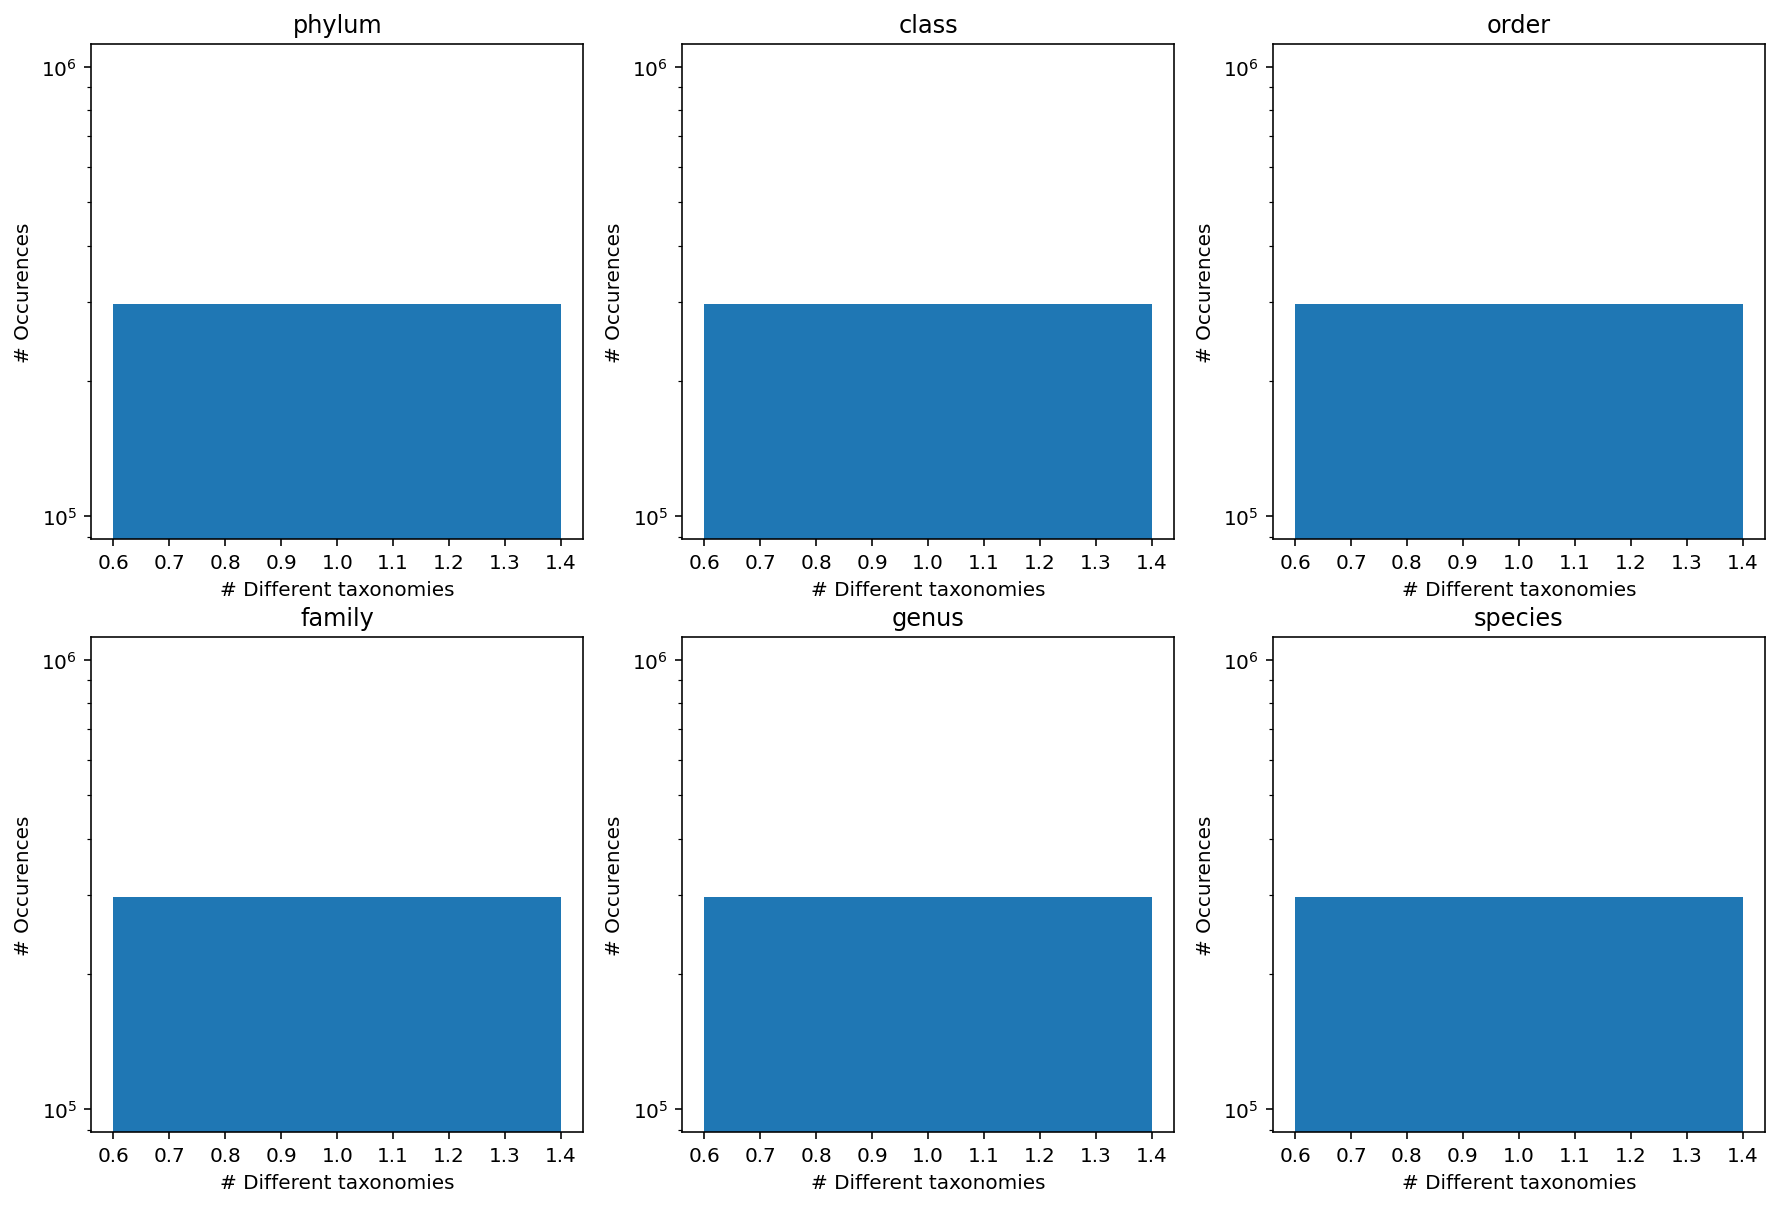

In [ ]:
plot_bar(df_1_tax_lens)

#### Create new look-up tsv with representative virus IDs:

In [ ]:
def merge_labels(x):
    # Remove "." from the tax arrays if there is more than one element
    if len(x) > 1:
        if "." in list(x):
            x = list(x)
            x.remove(".")

    return '_'.join(x)

In [ ]:
df_1_u_tax = df_1_tax.applymap(merge_labels)
df_1_u_tax = df_1_u_tax.reset_index()
df_1_u_tax = df_1_u_tax.rename(columns={"representative": "Label"})
df_1_u_tax

,Label,phylum,class,order,family,genus,species
0,u1,Pisuviricota,Pisoniviricetes,Nidovirales,Coronaviridae,Betacoronavirus,Severe acute respiratory syndrome-related coro...
1,u10,Negarnaviricota,Monjiviricetes,Mononegavirales,Filoviridae,Ebolavirus,Zaire ebolavirus
2,u100,Kitrinoviricota,Flasuviricetes,Amarillovirales,Flaviviridae,Flavivirus,West Nile virus
3,u1000,Negarnaviricota,Monjiviricetes,Mononegavirales,Paramyxoviridae,Henipavirus,Hendra henipavirus
4,u10000,Pisuviricota,Pisoniviricetes,Picornavirales,Caliciviridae,Norovirus,Norwalk virus
...,...,...,...,...,...,...,...
296556,u99995,.,.,.,.,.,.
296557,u99996,Lenarviricota,Howeltoviricetes,Cryppavirales,Mitoviridae,.,.
296558,u99997,.,.,.,.,.,.
296559,u99998,.,.,.,.,.,.


In [ ]:
# This virus ID to taxonomiy mapping will be further adjusted in the next notebook
df_1_u_tax.to_csv("u_tax_noduplicates.tsv", sep = "\t", index=False)